# Снижение размерности, 2026

Мы уже много раз сталкивались с необходимостью как-то перейти из пространства высокой размерности (вектора из Tf-Idf или word2vec) в пространство более низкой размерности.

Зачем это нам в целом может быть надо:
- Получить две координаты для визуализации, чтобы посмотреть, что у нас там в эмбеддингах;
- Упростить задачу методам ML, основанным на линейных расстояниях (KNN, KMeans etc): они начинают сильно хуже работать в пространствах высокой рамерности;
- Более эффективно упаковать данные и избавиться от шума: например, вектора от Tf-Idf сами по себе очень шумные (много случайных околонулевых значений), разреженные (множество нулей) и огромные (десятки тысяч значений), но мы можем уменьшить итоговую матрицу в разы почти без потери качетсва (а иногда и с улучшением).

Для таких целей применяются методы __снижения размерности__. Общая их идея - перейти в пространство меньшей размерности так, чтобы потерять как можно меньше информации об отношениях между объектами.

Такие алгоритмы могут быть построены двумя способами (возможно, есть еще, но эти основные):
1. Отбор признаков - выбираем нужное кол-во признаков из имеющихся. Часто используется в МЛ, но плохо работает с эмбеддингами, так как в основе лежит ожидание, что каждый признак что-то значит сам по себе;
2. Проекция признаков - преобразуем исходное кол-во характеристик в новое так, что новые характеристики представляют собой некоторую агрегацию старых.

Мы с вами сегодня посмотрим именно на вторую группу.

Такие алгоритмы можно также разделить на две категории:
- Алгоритмы, сохраняющие преимущественно макро-структуру данных. Они чаще всего основаны на максимизации сохраненной дисперсии и могут терять нюансы взаимного расположения конкретных точек. Сюда относятся PCA и SVD;
- Алгоритмы, сохраняющие локальную структуру данных. Они хорошо передают паттерны в том, как "кучкуются точки", однако не всегда выбирают лучший способ отображения с точки зрения сохранения макро-информации. Сюда относятся t-SNE и UMAP.

Посмотрим четыре наиболее популярных алгоритма.

## SVD (Singular Value Decomposition)

Общая идея метода - выделить в данных нужное кол-во ортотогональных направлений, вдоль которых будет максимальная дисперсия.

__Почему ортогональных?__ Мы хотим, чтобы полученные направления стали базисом нового пространства, в которое мы перенесем точки. А напрпавления координатных осей должны быть перпендикулярны друг другу.

__Почему сохраняем именно дисперисю?__ Чем больше разброс вдоль направления, тем больше информации о расположении точек мы сохраним, взяв это направление.

__Чуть больше на языке математики:__

Разложение для матрицы $X \in \mathbb{R}^{n \times d}$:

$$
X = U \, S \, V^T
$$

где:

- $U \in \mathbb{R}^{n \times n}$ — ортогональная матрица левых сингулярных векторов (даст координаты точек в новом базисе при домножении на нужную часть $S$);
- $S \in \mathbb{R}^{n \times d}$ — диагональная матрица сингулярных чисел (чем выше значение, тем выше дисперсия по соответствующему направлению - столбцу в $V$);  
- $V \in \mathbb{R}^{d \times d}$ — ортогональная матрица правых сингулярных векторов (новые базисные направления).

Снижение размерности до $k$ компонент выполняется проекцией на первые $k$ столбцов $V$:

$$
X_{\text{reduced}} = X \, V_k
$$

где $V_k \in \mathbb{R}^{d \times k}$ содержит первые $k$ правых сингулярных векторов, соответствующих наибольшим сингулярным числам.

Еще более подробно вам должны были рассказать на курсе по линейной алгебре :)

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap

from sklearn.datasets import (
    make_blobs,
    make_circles,
    make_swiss_roll,
    make_s_curve,
)

Теперь посмотрим на практике. Сгенерируем эллипс

In [ ]:
# Тут можно разобраться, если интересно.
# Но в остальном - это чистый линал в питоне

n_points = 500

# Сгенерируем сначала просто неровный шарик, как делали с кластеризацией
X, _ = make_blobs(n_samples=n_points, centers=[[0, 0, 0], ], n_features=3, random_state=42)

# Теперь растянем, чтобы получился эллипс
scale = np.diag([5, 2, 1])
X_scaled = X @ scale

# А теперь повернем этот эллипс, чтобы было интереснее
theta_x = np.deg2rad(30)
theta_y = np.deg2rad(45)
theta_z = np.deg2rad(60)

Rx = np.array([[1, 0, 0],
               [0, np.cos(theta_x), -np.sin(theta_x)],
               [0, np.sin(theta_x), np.cos(theta_x)]])

Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
               [0, 1, 0],
               [-np.sin(theta_y), 0, np.cos(theta_y)]])

Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
               [np.sin(theta_z),  np.cos(theta_z), 0],
               [0, 0, 1]])

R = Rx @ Ry @ Rz
X_rot = X_scaled @ R.T

Что у нас получилось:

In [ ]:
# Визуализация, можно не вникать

fig = go.Figure(data=[go.Scatter3d(x=X_rot[:,0], y=X_rot[:,1], z=X_rot[:,2],
    mode='markers', marker=dict(size=3, color='blue', opacity=0.7)
)])

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y',
    zaxis_title='Z', aspectmode='data'))

fig.update_layout(height=800, width=800)

fig.show()

Теперь найдем здесь два наиболее "важных" направления с помощью SVD. Делаем руками, а не через библиотеку, так как в библиотеке не совсем стандартный SVD

In [ ]:
k = 2

# Разложение SVD
U, S, Vt = np.linalg.svd(X_rot, full_matrices=False)

# Берем k наиболее интересных направлений
Vt_k = Vt[:k, :]

# Делаем на них проекцию
X_svd = np.dot(X_rot, Vt_k.T)

Рисуем, что получилось

In [ ]:
# Визуализация, можно не вникать

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type":"scatter3d"}, {"type":"scatter"}]],
                    subplot_titles=("Облако с направлениями SVD", "Проекция на 2D"))

fig.add_trace(go.Scatter3d(
    x=X_rot[:,0], y=X_rot[:,1], z=X_rot[:,2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7)
), row=1, col=1)

scale_factor = 0.1

for i in range(len(S)):
    fig.add_trace(go.Scatter3d(
        x=[0, Vt[i,0] * S[i] * scale_factor],
        y=[0, Vt[i,1] * S[i] * scale_factor],
        z=[0, Vt[i,2] * S[i] * scale_factor],
        mode='lines+markers',
        marker=dict(size=2, color='red'),
        line=dict(width=4, color='red'),
        name=f'PC{i+1}'
    ))

X_2d = X_rot @ Vt[:2,:].T
fig.add_trace(go.Scatter(
    x=X_2d[:,0], y=X_2d[:,1],
    mode='markers',
    marker=dict(size=4, color='green', opacity=0.7)
), row=1, col=2)

fig.update_layout(
    height=600, width=1200,
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    showlegend=False
)

axis_range = (-12, 12)
fig.update_layout(scene=dict(
    xaxis=dict(title='X', range=axis_range),
    yaxis=dict(title='Y', range=axis_range),
    zaxis=dict(title='Z', range=axis_range),
    aspectmode='data'
))
fig.update_xaxes(range=axis_range, row=1, col=2)
fig.update_yaxes(range=axis_range, row=1, col=2)


fig.show()

На картинке слева можно увидеть, что направления SVD совпадают с направлениями "вытяннусти" эллипса. Причем если мы разврнем картинку так, чтобы третью самую маленькую стредку не было видно, мы получим форму приблизительно похожую на картинку справа.

Это то, как работает SVD: фактически, мы ищем удачный ракурс для фотографии

Посмотрим, как это сделать через библиотеку. Лучше делать именно так, так как там есть алгоритмические оптимизации для работы с большими матрицами

In [ ]:
X_svd_skl = TruncatedSVD(n_components=2).fit_transform(X_rot)

In [ ]:
# Визуализация, можно не вникать

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=X_svd[:,0], y=X_svd[:,1],
    mode='markers',
    marker=dict(size=4, color='green', opacity=0.7),
    name='SVD руками'
))

fig.add_trace(go.Scatter(
    x=X_svd_skl[:,0], y=X_svd_skl[:,1],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='TruncatedSVD'
))

fig.update_xaxes(range=axis_range)
fig.update_yaxes(range=axis_range)

fig.update_layout(height=500, width=700,
                  title="SVD руками VS TruncatedSVD")
fig.show()

Как можно увидеть, результаты визуально похожи, но один в один не совпадают.

Задача на внимательность: что надо сделать с одной из матриц, чтобы совпали?

## PCA (Principal Component Analysis)

Отличие PCA от SVD заключается в центрировании данных без их масштабирования:
$$
\tilde{X} = X - X.\mathrm{mean}(\text{axis}=0)
$$

Обычно
- Центрирование - вычитание среднего;
- Масштабирование - деление на стандартное отклонение.

Для наших данных PCA и SVD должны работать почти одинаково, так как центр и так около нуля (изначально он там и был, но мы потом крутили и растягивали картинку)

In [ ]:
X_pca = PCA(n_components=2).fit_transform(X)

X_svd = TruncatedSVD(n_components=2).fit_transform(X)

In [ ]:
# Визуализация, можно не вникать

fig = go.Figure()

axis_range = (-4, 4)

fig.add_trace(go.Scatter(
    x=X_svd[:,0], y=X_svd[:,1],
    mode='markers',
    marker=dict(size=4, color='green', opacity=0.7),
    name='SVD'
))

fig.add_trace(go.Scatter(
    x=X_pca[:,0], y=X_pca[:,1],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='PCA'
))

fig.update_xaxes(range=axis_range)
fig.update_yaxes(range=axis_range)

fig.update_layout(height=500, width=700,
                  title="SVD VS PCA")
fig.show()

[Хорошая статья про это от Яндекса](https://education.yandex.ru/handbook/math/article/snizhenie-razmernosti-i-latentnie-faktori)

## T-SNE (T-distributed Stochastic Neighbor Embedding)

Исходно T-SNE был придуман именно для визуализации данных высокой размерности, так что лучше всего он переводит в 2-3d, с большей размерностью бывают проблемы.

T-SNE - это улучшение SNE, предложенного еще в 2002 году, применять всегда лучше T-SNE, так как он сейчас считается стандартом.

Общая идея: сохраняем локальные расстояниея за счет учета вероятности точек "быть соседями", при условии, что точки в области распределены нормально.


__Более подробно__ (можно пропустить)

Верхнеуровнево алгоритм:
- Фиксируем локальные расстояния, расчитывая для каждой пары точек вероятность быть соседями: очевидно, что чем ближе точки, тем выше будет это значение. Однако, природа нормального распределения заставит нас увеличивать близость для и так близких точек и сильно уменьшать ее - для далеких. Из-за этого TSNE иногда склонен сжимать кластеры чуть ли не в одну точку;

$$
p_{j|i} = \frac{\exp\Big(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\Big)}
                {\sum_{k \neq i} \exp\Big(-\frac{\|x_i - x_k\|^2}{2\sigma_i^2}\Big)}
$$

$\sigma_i^2$ здесь подбирается так, чтобы плотность локальных областей была примерно одинакова.

- Задаем формулой расстояния в пространстве малой размерности

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

- Дальше мы будем минимизировать разницу между $p$ и $q$ с помощью градиентного спуска, подбирая $y_i$

$$
\text{KL}(P \| Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

[Вот тут можно почитать __сильно__ подробнее](https://habr.com/ru/articles/267041/)

У алгоритма есть один гиперпараметр - perplexity. Чем он выше, тем меньше плотность ожидается у локальных областей, из-за чего возрастает вероятность соседства более далеких точек.

In [ ]:
X_tsne = TSNE(n_components=2, random_state=42, perplexity=10).fit_transform(X)
X_tsne_glob = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(X)

In [ ]:
# Визуализация, можно не вникать

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type":"scatter3d"}, {"type":"scatter"}]],
                    subplot_titles=("Облако", "Проекция TSNE"))

fig.add_trace(go.Scatter3d(
    x=X_rot[:,0], y=X_rot[:,1], z=X_rot[:,2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7),
    name='3d'
), row=1, col=1)

X_2d = X_tsne
fig.add_trace(go.Scatter(
    x=X_2d[:,0], y=X_2d[:,1],
    mode='markers',
    marker=dict(size=4, color='green', opacity=0.7),
    name='Lower N'
), row=1, col=2)

X_2d = X_tsne_glob
fig.add_trace(go.Scatter(
    x=X_2d[:,0], y=X_2d[:,1],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='Higher N'
), row=1, col=2)

fig.update_layout(
    height=600, width=1200,
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
)

axis_range = (-12, 12)
fig.update_layout(scene=dict(
    xaxis=dict(title='X', range=axis_range),
    yaxis=dict(title='Y', range=axis_range),
    zaxis=dict(title='Z', range=axis_range),
    aspectmode='data'
))


fig.show()

Что ж, он пытался. На самом деле, это просто один из самых сложных примеров для TSNE: так как он смотрит на локальную структуру, ему очень сложно правильно передавать макро-формы.

При более высокой перплексии он начинает лучше понимать глобальную структуру, но все равно уступает в этом SVD.

Дальше мы с вами посмотрим на примеры, где он сильно обгоняет SVD

## UMAP (Uniform Manifold Approximation and Projection)

В отличие от чисто вероятностного подхода TSNE, UMAP использует граф, на основе которого потом получаются вероятности.

Кратко алгоритм:
- Строим граф, где вершины - это точки из наших данных, а ребра связывают ближайших соседей (топ-N ближайших точек). Веса на ребрах - значения близости точек;
- С помощью специальной формулы оцениваем вероятность точек быть соседями;
- Строим в пространствен низкой размерности такой же граф и пытаемся минимизировать расхождения.

У алгоритма есть три гиперпараметра:

- n_neighbors - кол-во соседей для построения графа. Чем выше значение, тем больше алгоритм будет учитывать глобальную структуру данных;
- min_dist - минимальное расстояние между точками в итоговом графе. Чем больше, тем более разреженными будут точки в итоге;
- metric - метрика расстояния, чаще всего Евклид или косинус.

In [ ]:
X_umap = umap.UMAP(random_state=42, n_neighbors=5).fit_transform(X)
X_umap_glob = umap.UMAP(random_state=42, n_neighbors=50).fit_transform(X)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# Визуализация, можно не вникать

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type":"scatter3d"}, {"type":"scatter"}]],
                    subplot_titles=("Облако", "Проекция UMAP"))

fig.add_trace(go.Scatter3d(
    x=X_rot[:,0], y=X_rot[:,1], z=X_rot[:,2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7),
    name='3d'
), row=1, col=1)

X_2d = X_umap
fig.add_trace(go.Scatter(
    x=X_2d[:,0], y=X_2d[:,1],
    mode='markers',
    marker=dict(size=4, color='green', opacity=0.7),
    name='Lower N'
), row=1, col=2)

X_2d = X_umap_glob
fig.add_trace(go.Scatter(
    x=X_2d[:,0], y=X_2d[:,1],
    mode='markers',
    marker=dict(size=4, color='orange', opacity=0.7),
    name='Higher N'
), row=1, col=2)

fig.update_layout(
    height=600, width=1200,
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
)

axis_range = (-12, 12)
fig.update_layout(scene=dict(
    xaxis=dict(title='X', range=axis_range),
    yaxis=dict(title='Y', range=axis_range),
    zaxis=dict(title='Z', range=axis_range),
    aspectmode='data'
))


fig.show()

Как и ожидалось, похоже на TSNE. Плюсы и минусы у них достаточно похожи, но UMAP считается более мощным, так как справляется с большим разнообразием задач.

## Сравнение на интересных примерах

Мы уже поняли, что SVD хорошо справляется с переложением шариков в меньшую размерность, а TSNE и UMAP справляются с этим плохо. Но есть множество более сложных форм, где соотношение алгоритмов не так однозначно

### Код для визуализации

In [ ]:
def plot_4_decompositions(X, color=None):
    n_samples = X.shape[0]

    if color is None:
        color = np.arange(n_samples)

    X_pca = PCA(n_components=2).fit_transform(X)
    X_svd = TruncatedSVD(n_components=2).fit_transform(X)
    X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
    X_umap = umap.UMAP(random_state=42).fit_transform(X)

    fig = make_subplots(
        rows=2, cols=3,
        column_widths=[0.55, 0.225, 0.225],
        specs=[
            [{"type": "scene", "rowspan": 2}, {"type": "xy"}, {"type": "xy"}],
            [None, {"type": "xy"}, {"type": "xy"}]
        ],
        subplot_titles=("3D Data", "PCA", "SVD", "t-SNE", "UMAP")
    )

    fig.add_trace(
        go.Scatter3d(
            x=X[:,0], y=X[:,1], z=X[:,2],
            mode="markers",
            marker=dict(size=2, color=color, colorscale="Spectral"),
            showlegend=False
        ),
        row=1, col=1
    )

    def add_2d(data, row, col):
        fig.add_trace(
            go.Scatter(
                x=data[:,0], y=data[:,1],
                mode="markers",
                marker=dict(size=3, color=color, colorscale="Spectral"),
                showlegend=False
            ),
            row=row,
            col=col
        )

    add_2d(X_pca, 1, 2)
    add_2d(X_svd, 1, 3)
    add_2d(X_tsne, 2, 2)
    add_2d(X_umap, 2, 3)

    fig.update_layout(height=900, width=1400)
    fig.show()

### Картинки

Посмотрим, что будет, если у нас будет несолько шариков в пространстве

In [ ]:
X, color = make_blobs(n_samples=500, centers=[[0,0,0], [5,5,5]], cluster_std=1.5, random_state=42)
plot_4_decompositions(X, color)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



А теперь на случай, где на самом деле у нас две размерности, но есть третья нулевая

In [ ]:
X, color = make_circles(n_samples=1000, factor=0.5, noise=0.05, random_state=42)

# Сделам так, чтобы наши данные имели третью нулевую размерность
X = np.hstack([X, np.zeros((X.shape[0], 1))])

plot_4_decompositions(X, color)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



А теперь более интересные формы

In [ ]:
X, color = make_swiss_roll(n_samples=2000, noise=0.05, random_state=42)

plot_4_decompositions(X, color)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
X, color = make_s_curve(n_samples=2000, noise=0.05, random_state=42)
plot_4_decompositions(X, color)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



На последних двух видно, что PCA справляется лучше, чем SVD. Это происходит из-за центрирования данных

И еще один интересный пример, где SVD позволяет избавиться от шума

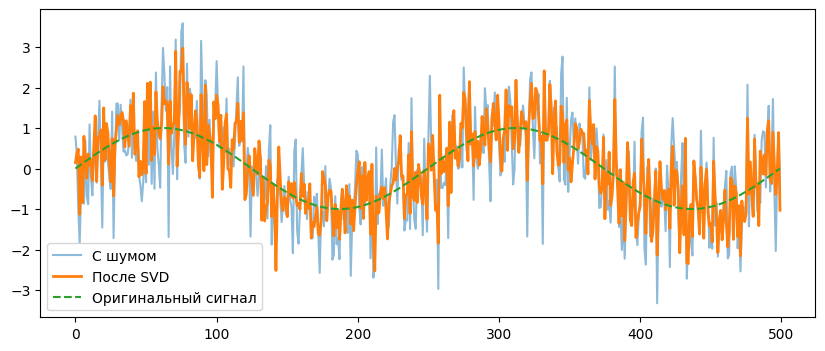

In [ ]:
# Создадим синусоиду
x = np.linspace(0, 4*np.pi, 500)
y = np.sin(x)
signal = np.vstack([y, y]).T  # 2D сигнал

# Теперь испортим ее, добавим случайный шум
noise = np.random.normal(scale=0.9, size=signal.shape)
X_noisy = signal + noise

# SVD
U, S, Vt = np.linalg.svd(X_noisy, full_matrices=False)

# Оставим только 1 компоненту
k = 1
S_k = np.zeros_like(S)
S_k[:k] = S[:k]

# Восстановим данные
X_denoised = (U * S_k) @ Vt

# Нарисуем
plt.figure(figsize=(10,4))
plt.plot(X_noisy[:,0], label="С шумом", alpha=0.5)
plt.plot(X_denoised[:,0], label="После SVD", linewidth=2)
plt.plot(signal[:,0], '--', label="Оригинальный сигнал")
plt.legend()
plt.show()

__Итого__

SVD/PCA лучшие для:
- Данных с линейной структурой;
- Задачи снижения уровня шума в данных (аккуратно, можно потерять полезную информацию, не любая маленькая дисперсия - это шум);
- Feature extraction - та самая задача перевода Tf-Idf матрицы во что-то более осмысленное и компактное.

t-SNE/UMAP лучшие для:
- Визуализации, особенно если у нас эмбеддинги;
- Нелинейных форм.